In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import torch
import torch.nn as nn
import xlrd

 

      Cement (component 1)(kg in a m^3 mixture)  \
0                                         540.0   
1                                         540.0   
2                                         332.5   
3                                         332.5   
4                                         198.6   
...                                         ...   
1025                                      276.4   
1026                                      322.2   
1027                                      148.5   
1028                                      159.1   
1029                                      260.9   

      Blast Furnace Slag (component 2)(kg in a m^3 mixture)  \
0                                                   0.0       
1                                                   0.0       
2                                                 142.5       
3                                                 142.5       
4                                                 132.4       
...      

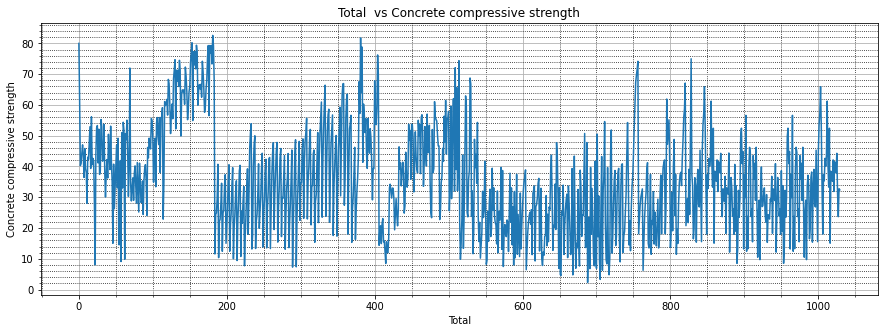

In [2]:

data = pd.read_excel('Concrete_Data.xls')
print(data)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size
plt.minorticks_on()
plt.grid(which='minor',  color = 'k',  linestyle = ':')
plt.title('Total  vs Concrete compressive strength')
plt.ylabel('Concrete compressive strength')
plt.xlabel('Total')
plt.grid(True)
 
plt.plot(data['Concrete compressive strength(MPa, megapascals) '])

In [3]:
test_data_size = 8

train_data = data['Concrete compressive strength(MPa, megapascals) '][:-test_data_size]
test_data = data['Concrete compressive strength(MPa, megapascals) '][-test_data_size:]

In [4]:
print(len(train_data))
print(len(test_data))

1022
8


In [5]:
from sklearn.preprocessing import MinMaxScaler
#нормализация данных
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data.values.reshape(-1, 1))
print(train_data_normalized[:5])
print(train_data_normalized[-5:])


[[ 0.93488979]
 [ 0.4839286 ]
 [-0.05471662]
 [-0.03520074]
 [ 0.0456115 ]]
[[-0.09977838]
 [-0.12956759]
 [-0.18040166]
 [-0.00810871]
 [-0.26387672]]


In [6]:
#преобразование нашего набора данных в тензоры
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
train_window = 12

In [7]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [8]:
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)
train_inout_seq[:5]

[(tensor([ 0.9349,  0.4839, -0.0547, -0.0352,  0.0456,  0.1137,  0.0307, -0.1499,
           0.0844, -0.0791, -0.1094, -0.3599]),
  tensor([0.0136])),
 (tensor([ 0.4839, -0.0547, -0.0352,  0.0456,  0.1137,  0.0307, -0.1499,  0.0844,
          -0.0791, -0.1094, -0.3599,  0.0136]),
  tensor([-0.0035])),
 (tensor([-0.0547, -0.0352,  0.0456,  0.1137,  0.0307, -0.1499,  0.0844, -0.0791,
          -0.1094, -0.3599,  0.0136, -0.0035]),
  tensor([0.1333])),
 (tensor([-0.0352,  0.0456,  0.1137,  0.0307, -0.1499,  0.0844, -0.0791, -0.1094,
          -0.3599,  0.0136, -0.0035,  0.1333]),
  tensor([0.2602])),
 (tensor([ 0.0456,  0.1137,  0.0307, -0.1499,  0.0844, -0.0791, -0.1094, -0.3599,
           0.0136, -0.0035,  0.1333,  0.2602]),
  tensor([-0.0774]))]

In [9]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [10]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)


LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


In [11]:
epochs = 200

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')


epoch:   1 loss: 0.01130700
epoch:  26 loss: 0.00178780
epoch:  51 loss: 0.00021456
epoch:  76 loss: 0.05447441
epoch: 101 loss: 0.00160268
epoch: 126 loss: 0.00002949
epoch: 151 loss: 0.00009836
epoch: 176 loss: 0.00171677
epoch: 199 loss: 0.0003113513


In [12]:
fut_pred = 8

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

[-0.05988764762878418, 0.03320792317390442, 0.4676939845085144, -0.0397876612842083, -0.2282121330499649, 0.24819186329841614, -0.682076632976532, -0.09977838397026062, -0.12956759333610535, -0.18040165305137634, -0.008108711801469326, -0.26387670636177063]


In [13]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

test_inputs[fut_pred:]

[-0.12956759333610535,
 -0.18040165305137634,
 -0.008108711801469326,
 -0.26387670636177063,
 0.06955555081367493,
 -0.13393256068229675,
 0.18649516999721527,
 -0.1542799025774002,
 -0.18421120941638947,
 -0.288579523563385,
 -0.1659809947013855,
 -0.3514941930770874]

In [14]:
import numpy as np
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
print(actual_predictions)


[[45.25703852]
 [37.09030597]
 [49.9502591 ]
 [36.27369168]
 [35.07243734]
 [30.88374984]
 [35.80408346]
 [28.35875084]]


In [15]:
x = np.arange(1031, 1039, 1)
print(x)


[1031 1032 1033 1034 1035 1036 1037 1038]


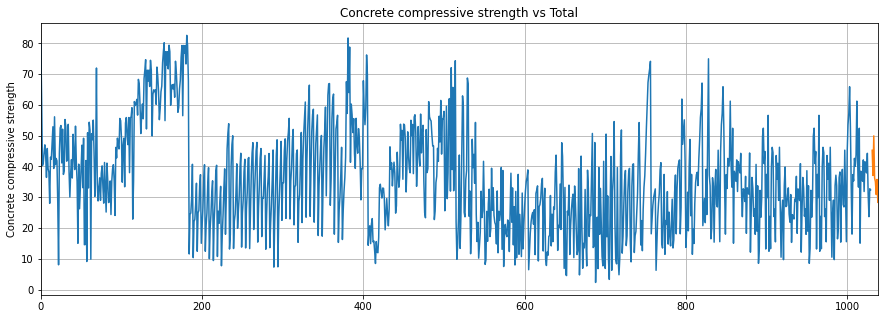

In [16]:
plt.title('Concrete compressive strength vs Total')
plt.ylabel('Concrete compressive strength')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(data['Concrete compressive strength(MPa, megapascals) '])
plt.plot(x,actual_predictions)
plt.show()

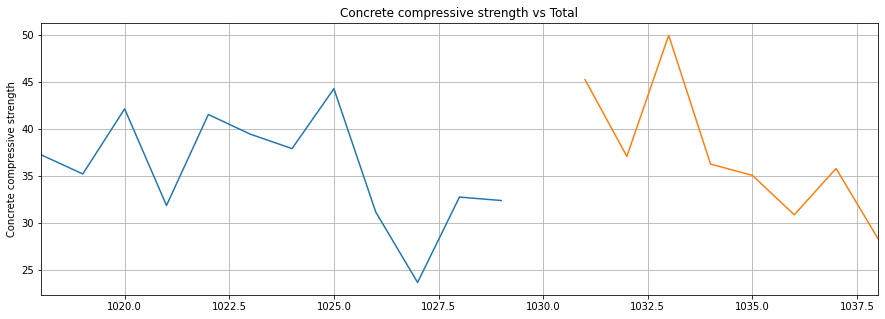

In [17]:
plt.title('Concrete compressive strength vs Total')
plt.ylabel('Concrete compressive strength')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(data['Concrete compressive strength(MPa, megapascals) '][-train_window:])
plt.plot(x,actual_predictions)
plt.show()


In [18]:
fut_pred = 8

[   1    2    3 ... 1028 1029 1030]
[79.98611076 61.88736576 40.26953526 ... 23.69660064 32.76803638
 32.40123514]
intercept: 44.82312042323242
slope: [-0.01746903]
predicted response:
[44.80565139 44.78818236 44.77071334 ... 26.86495832 26.84748929
 26.83002026]


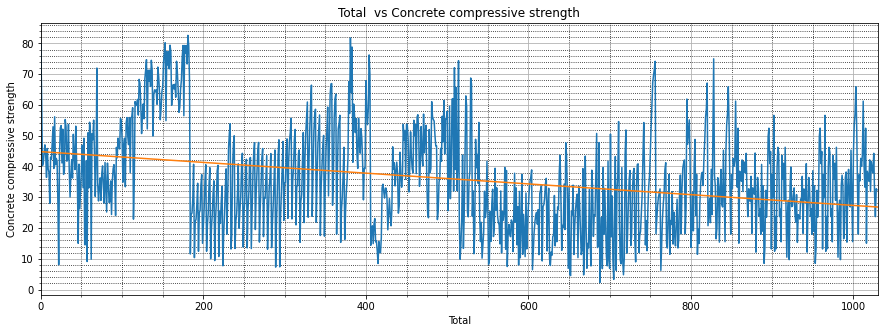

In [19]:
data['ind'] = range(1, len(data) + 1)
x = data.iloc[:, -1].values
y = data.iloc[:, 8].values
print(x)

print(y)
model = LinearRegression().fit(x.reshape(-1, 1), y)
print('intercept:', model.intercept_)
print('slope:', model.coef_)
y_pred = model.predict(x.reshape(-1, 1))
print('predicted response:', y_pred, sep='\n')
plt.title('Total  vs Concrete compressive strength')
plt.ylabel('Concrete compressive strength')
plt.xlabel('Total')
plt.grid(True)
plt.minorticks_on()
plt.grid(which='minor',  color = 'k',  linestyle = ':')
plt.autoscale(axis='x', tight=True)
plt.plot(data['Concrete compressive strength(MPa, megapascals) '])
plt.plot(x,y_pred)
plt.show()

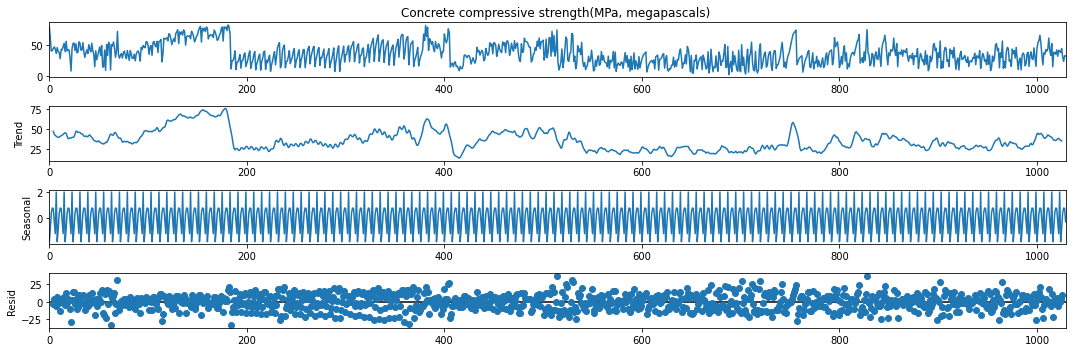

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data['Concrete compressive strength(MPa, megapascals) '], period=8)
decomposition.plot()
plt.show()